In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Datasets/jena_climate_2009_2016.csv

Archive:  gdrive/My Drive/Datasets/jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
fname='jena_climate_2009_2016.csv'

In [ ]:
f=open(fname)

In [ ]:
data=f.read()

In [ ]:
lines=data.split('\n')

In [ ]:
len(lines)

420452

In [ ]:
header=lines[0].split(',')

In [ ]:
lines=lines[1:]

In [ ]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [ ]:
import numpy as np

In [ ]:
mat=np.zeros((len(lines),len(header)-1))
mat2=np.zeros((len(lines),len(header)-1))

In [ ]:
for i,line in enumerate(lines):
  values=[float(x) for x in line.split(',')[1:]]
  mat[i,:]=values

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
temp=mat[:,1]

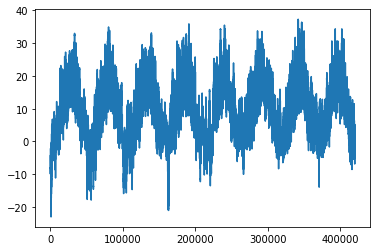

In [ ]:
plt.plot(range(0,len(temp)),temp)
plt.show()

In [ ]:
mean=mat[:200000].mean(axis=0)

In [ ]:
mat=mat-mean

In [ ]:
std=mat[:200000].std(axis=0)

In [ ]:
mat=mat/std

In [ ]:
mat

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [ ]:
mean

array([ 988.88635885,    9.07734895,  283.14631345,    4.44854725,
         75.35405895,   13.3829553 ,    9.29695535,    4.08591725,
          5.8752111 ,    9.40521005, 1217.51429655,    2.1510037 ,
          3.56950915,  176.21703355])

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [ ]:
train_gen = generator(mat,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)

In [ ]:
val_gen = generator(mat,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)

In [ ]:
test_gen = generator(mat,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)

In [ ]:
val_steps = (300000 - 200001 - lookback)

In [ ]:
test_steps = (len(mat) - 300001 - lookback)

In [ ]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))
evaluate_naive_method()

0.28969941979609765


In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, mat.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 885s 2s/step - loss: 1.8116 - val_loss: 0.6708
Epoch 2/20
499/500 [============================>.] - ETA: 0s - loss: 0.4797

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.2,
recurrent_dropout=0.2,
input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
dropout=0.1,
recurrent_dropout=0.5,
return_sequences=True,
input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
dropout=0.1,
recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500,
epochs=40,
validation_data=val_gen,
validation_steps=val_steps)